<a href="https://colab.research.google.com/github/soupsoupr/StrokeSegmentation/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load and pre-process data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import nibabel as nib
import os
# Set the file path to the directory containing the DWI data files
file_path = '/content/drive/MyDrive/ISLES/dataset-ISLES22^public^unzipped^version'

In [ ]:
n = 50  # Number of data sets - there are 250 cases in total
data_list = []  # Initialize an empty list to store the data pairs

for example_case in range(1,n+1): # for the first 10 data from ISLES22
    # Set images path.
    dwi_path = os.path.join(file_path, 'rawdata', 'sub-strokecase{}'.format("%04d" %example_case), 'ses-0001',
                            'sub-strokecase{}_ses-0001_dwi.nii.gz'.format("%04d" %example_case))
    mask_path = dwi_path.replace('rawdata', 'derivatives').replace('dwi', 'msk')

    dwi_data = nib.load(dwi_path).get_fdata()
    mask_data = nib.load(mask_path).get_fdata()

    # Slice from the middle slice
    # slice_index = 40
    slice_index = dwi_data.shape[2] // 2

    # Extract the 2D slice from the 3D volume
    slice_dwi_data = dwi_data[:, :, slice_index]
    slice_mask_data = mask_data[:, :, slice_index]

    data_list.append((slice_dwi_data, slice_mask_data))

# Perform segmentation to DWI data

In [ ]:
# Method 1 - percentile-based segmentation
import numpy as np

def percentile_segmentation(dwi_image, percentile=99.6):
    # Calculate the percentile threshold
    threshold = np.percentile(dwi_image, percentile)

    # Create a binary mask based on the threshold
    segmentation = dwi_image > threshold

    return segmentation

In [ ]:
# Method 2 - thresholding
import numpy as np

def thresholding_segmentation(dwi_image, threshold):
    segmentation = (dwi_image > threshold).astype(np.uint8)
    return segmentation

In [ ]:
# Method 3 - region growing
import numpy as np

def region_growing_segmentation(image, seed, threshold):
    visited = np.zeros_like(image)
    stack = [seed]
    while stack:
        x, y = stack.pop()
        if visited[x, y] == 1:
            continue
        visited[x, y] = 1
        # Add neighboring pixels based on similarity criteria
        if x > 0 and np.abs(image[x, y] - image[x - 1, y]) < threshold:
            stack.append((x - 1, y))
        # Add other neighboring pixels similarly
    return visited

In [ ]:
# Method 4 - active contour (snake) model
import cv2
import numpy as np

def active_contour_segmentation(dwi_image, initial_points):
    mask = np.zeros_like(dwi_image)
    snake_points = np.array(initial_points, dtype=np.int32).reshape((-1, 1, 2))
    cv2.fillPoly(mask, [snake_points], 1)
    return mask

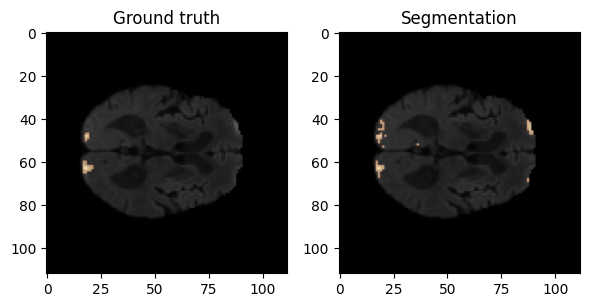

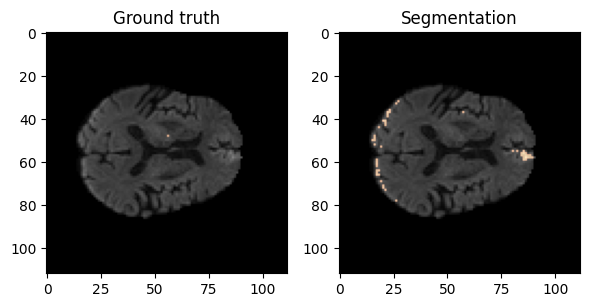

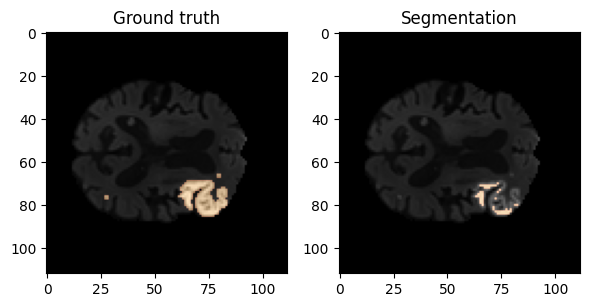

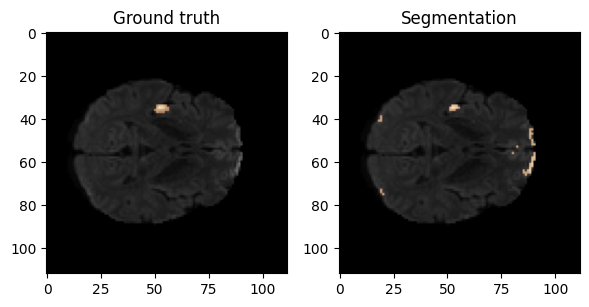

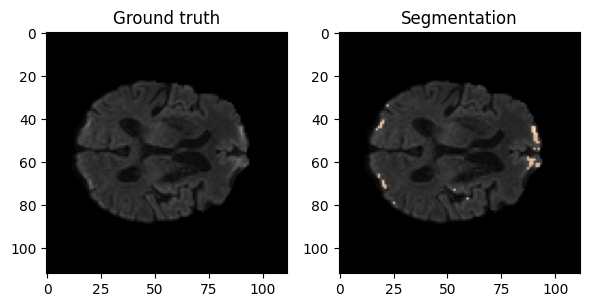

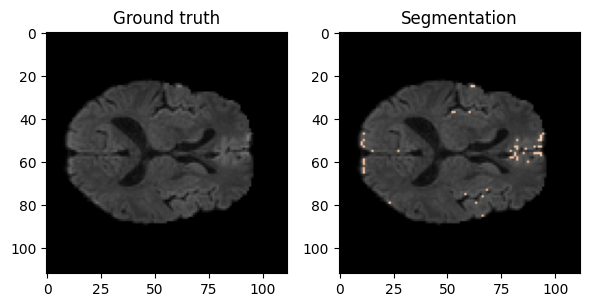

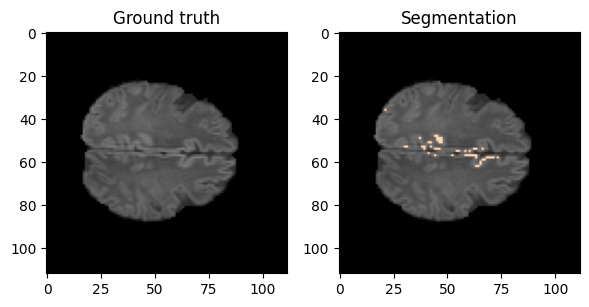

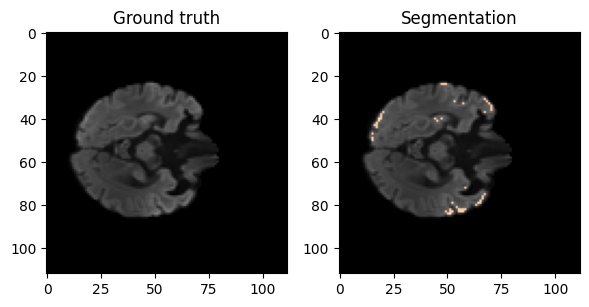

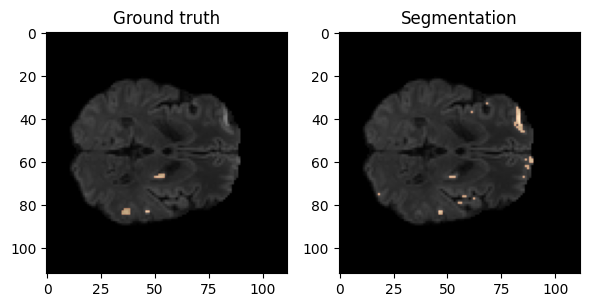

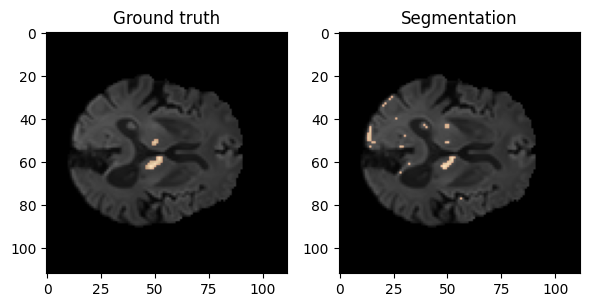

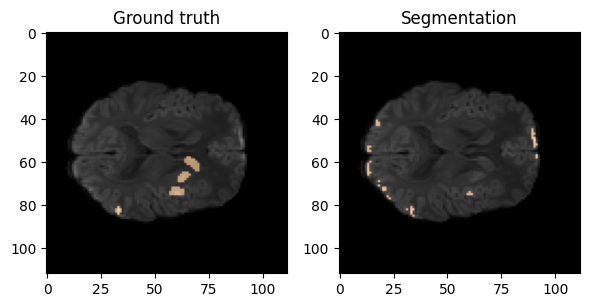

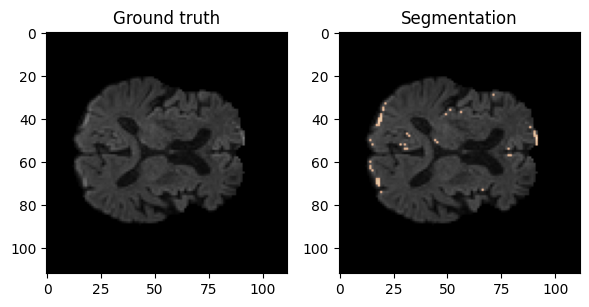

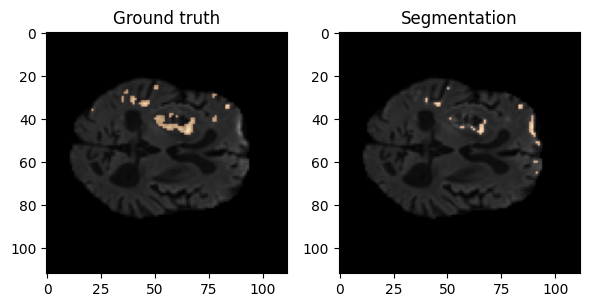

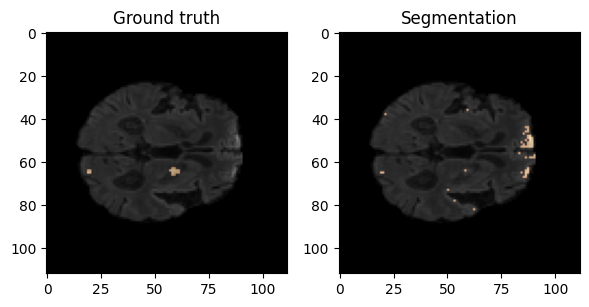

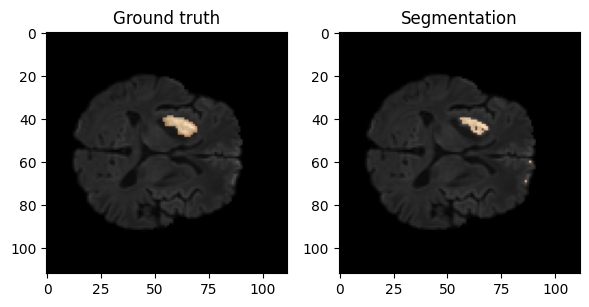

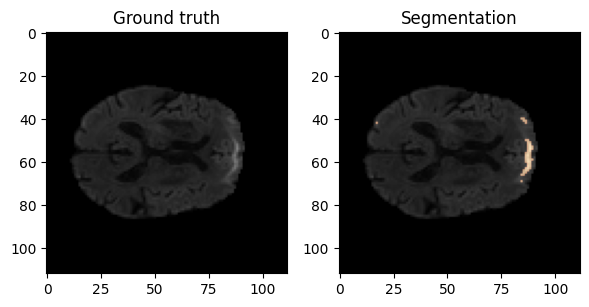

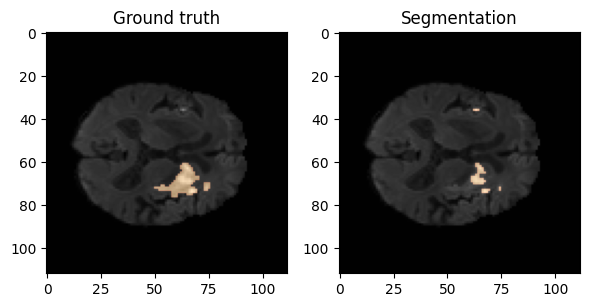

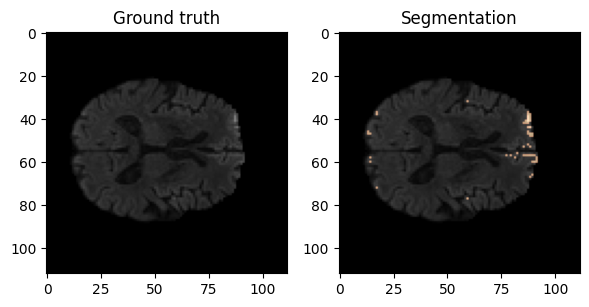

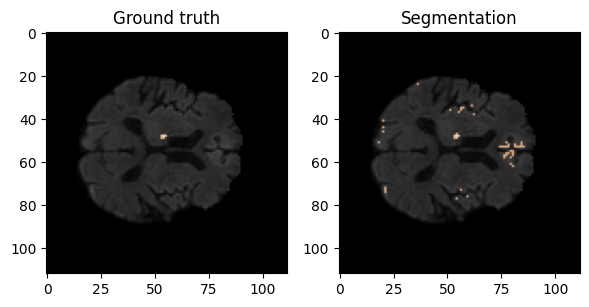

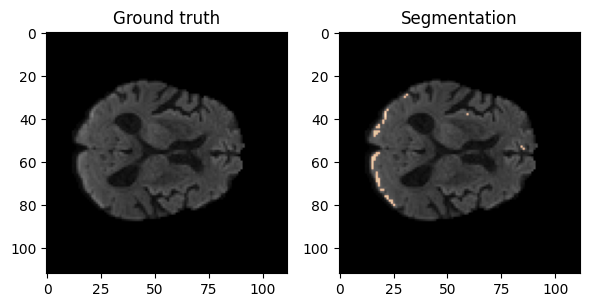

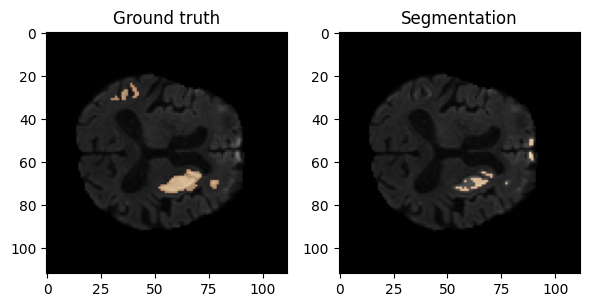

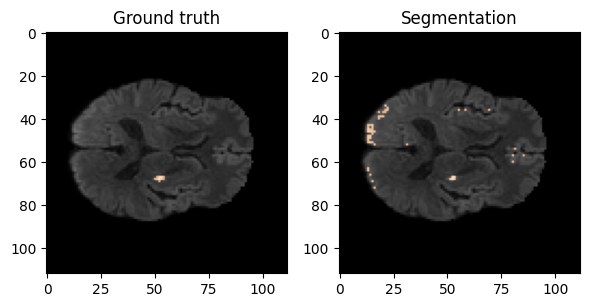

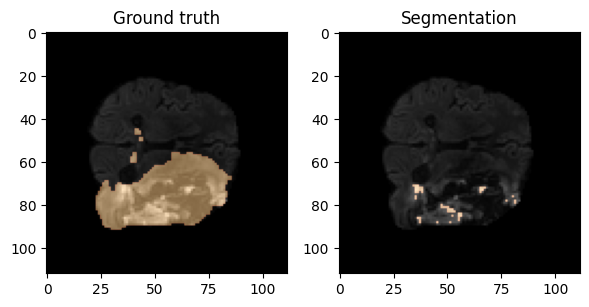

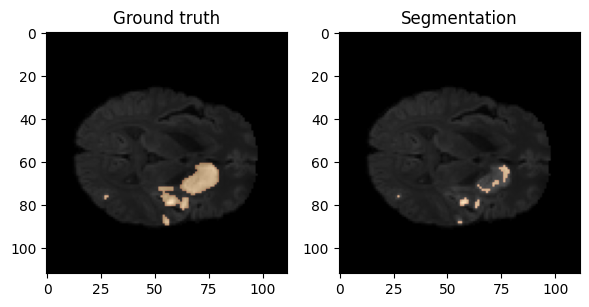

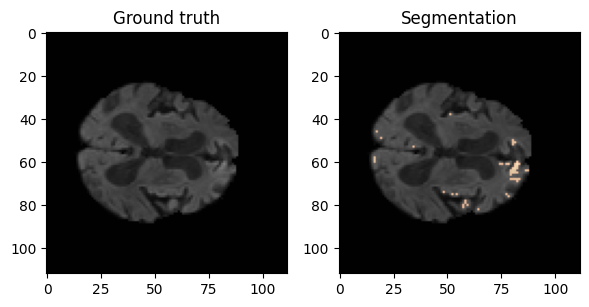

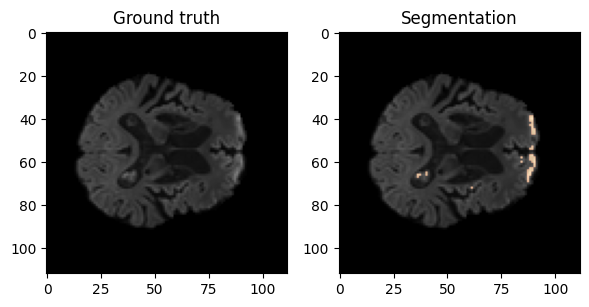

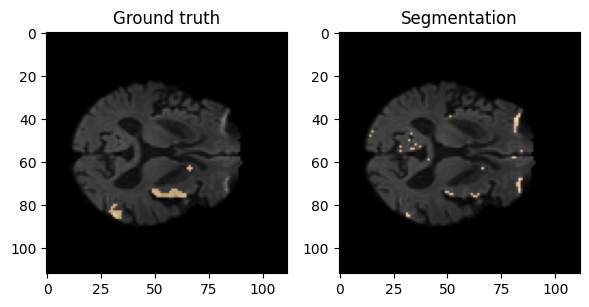

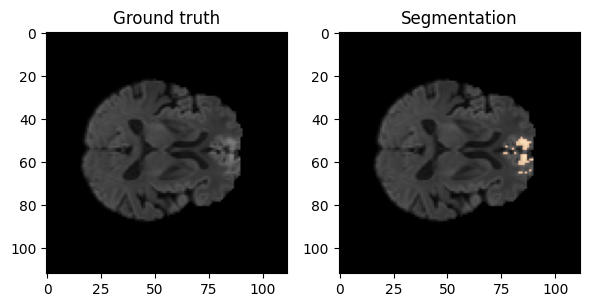

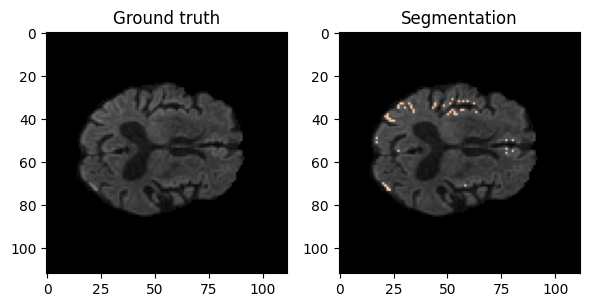

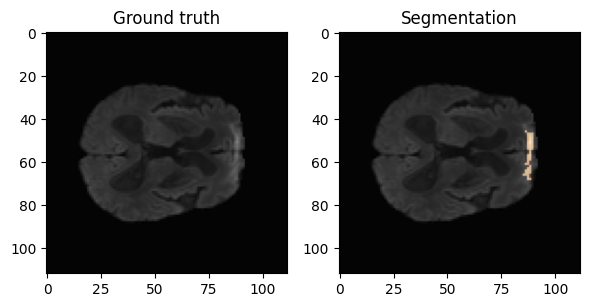

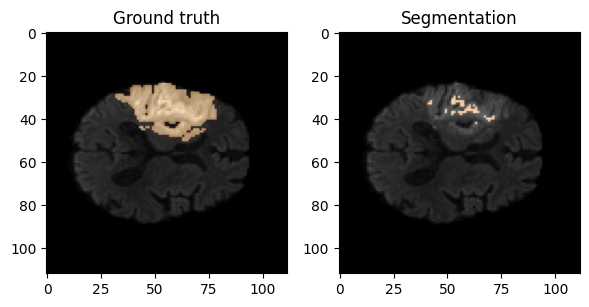

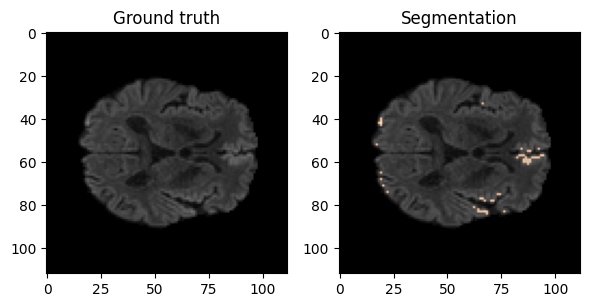

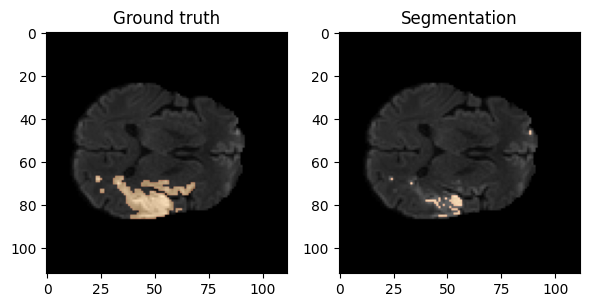

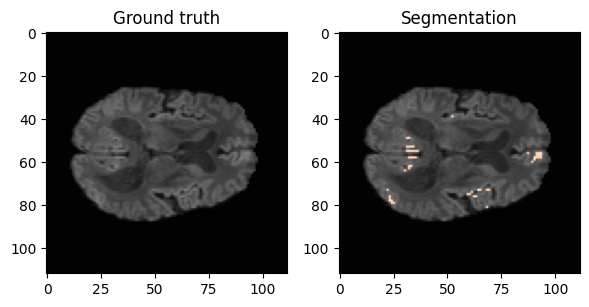

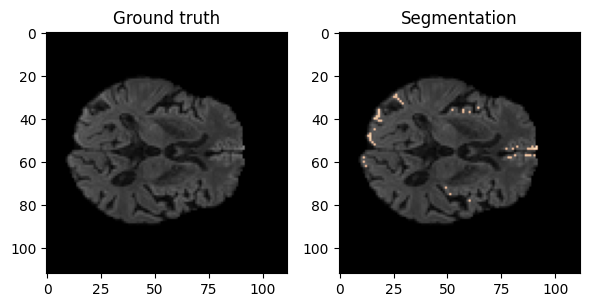

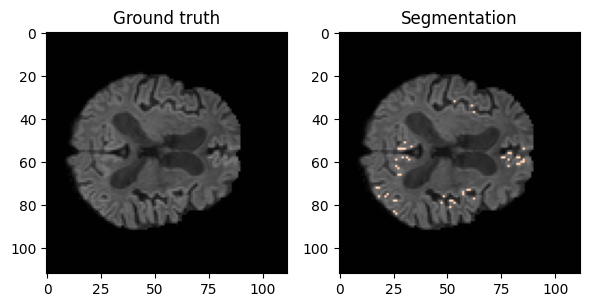

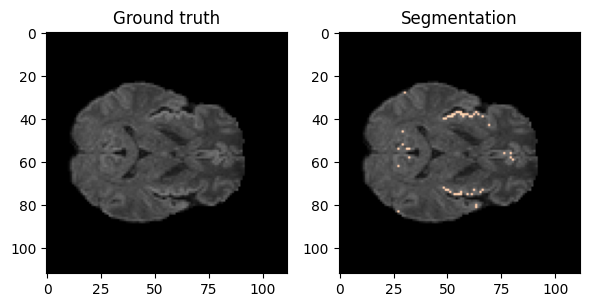

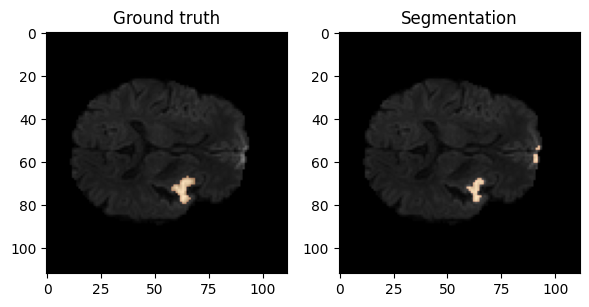

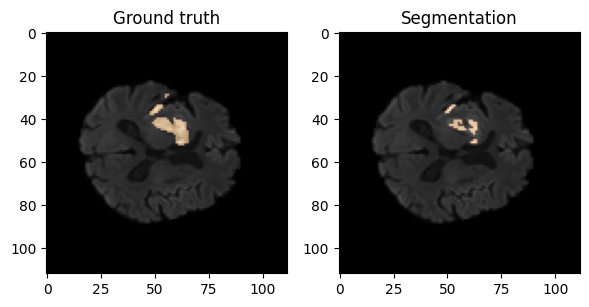

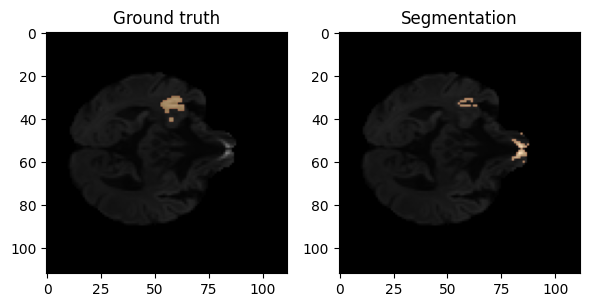

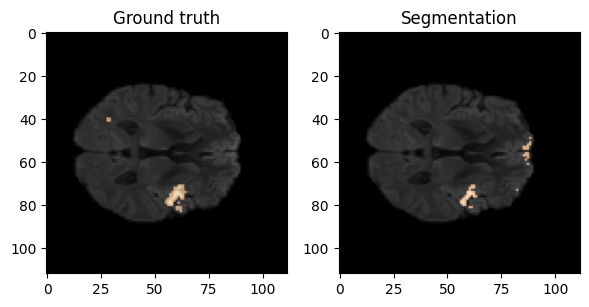

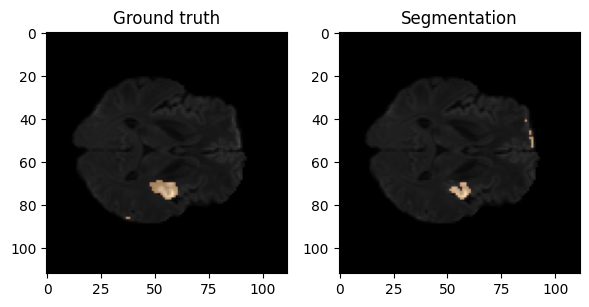

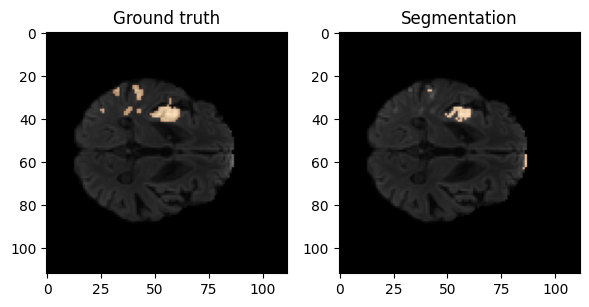

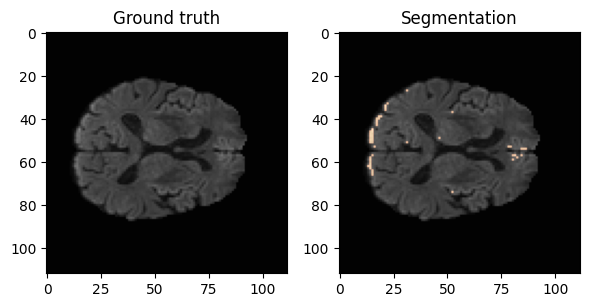

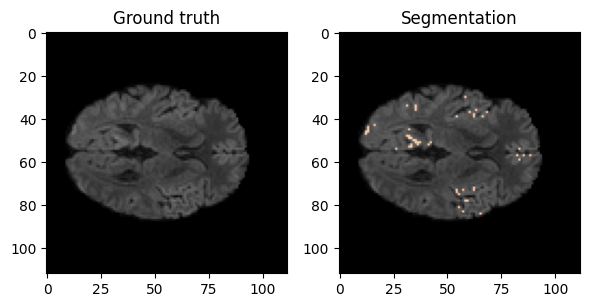

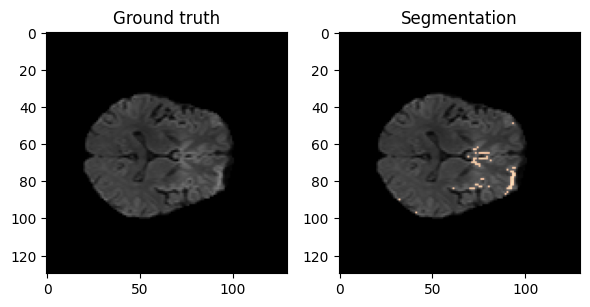

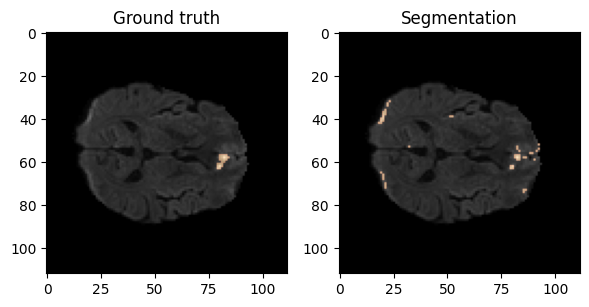

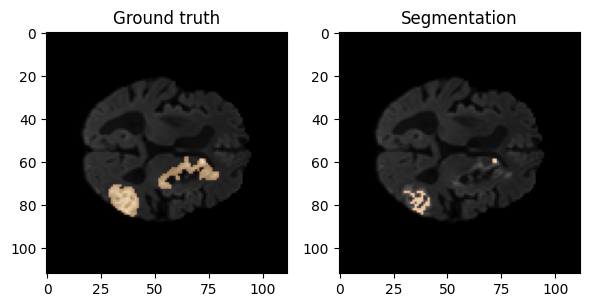

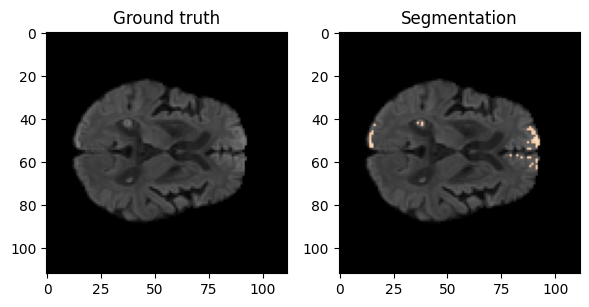

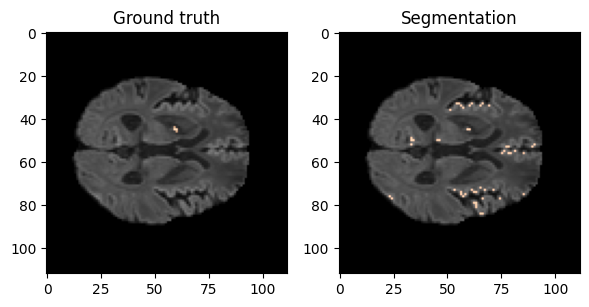

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion, binary_dilation

segmentations = [] # create a new list for segmentation

for dwi_image, mask_data in data_list:
    predicted_mask = percentile_segmentation(dwi_image, percentile=99.6) # method 1
    # predicted_mask = thresholding_segmentation(dwi_image, 500) # method 2
    # predicted_mask = region_growing_segmentation(dwi_image, (50,50), 500) # method 3
    # predicted_mask = active_contour_segmentation(dwi_image, (50,50)) # method 4

    # Perform post-processing (e.g., erosion and dilation)
    segmentation_mask = binary_erosion(predicted_mask, iterations=1)
    segmentation_mask = binary_dilation(predicted_mask, iterations=1)

    segmentations.append((dwi_image, predicted_mask))

    # Compare ground truth and segmentation
    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(dwi_image, cmap='gray')
    plt.imshow(mask_data, alpha=0.5, cmap='copper')
    plt.title('Ground truth')

    plt.subplot(1, 2, 2)
    plt.imshow(dwi_image, cmap='gray')
    plt.imshow(predicted_mask, alpha=0.5, cmap='copper')
    plt.title('Segmentation')

    plt.tight_layout()
    plt.show()

# Import ibraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Split dataset into training and testing sets

In [ ]:
from sklearn.model_selection import train_test_split

# separate data into X and y
X = [dwi_data for dwi_data, _ in segmentations]  # Assuming DWI data is X
y = [pred_mask_data for _, pred_mask_data in segmentations]  # Assuming mask data is y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom PyTorch dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__ (self, data_list, transformer):
        self.data_list = data_list
        self.transformer = transformer

    def __len__ (self):
        return len(self.data_list)

    def __getitem__ (self, index):
        dwi_data, mask_data = self.data_list[index]
        return dwi_data, mask_data

# Data preprocessing and augmentation

In [ ]:
train_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

test_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

# Create data loaders

In [ ]:
# Train and test sets initalization
train_dataset = CustomDataset(segmentations, train_transformer)
test_dataset = CustomDataset(segmentations, test_transformer)

In [ ]:
# Train and test set data loaders initalization
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

Check data shape
*   shape form [in_channels, height, width]


In [ ]:
# Iterate through the data loader
for batch_idx, (image, pred_mask) in enumerate(train_loader):

    print(f'DWI image shape: {image.shape}')
    print(f'Mask shape: {pred_mask.shape}')

    break

DWI image shape: torch.Size([1, 112, 112])
Mask shape: torch.Size([1, 112, 112])


# Define the U-Net Model

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder(x)
        # Decoder
        x2 = self.decoder(x1)
        return x2

# Instantiate the U-Net model

In [ ]:
in_channels = 1  # DWI images channels
out_channels = 1  # masks channel
model = UNet(in_channels, out_channels)

# Model training

In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.float()  # Convert input data to float32
        labels = labels.float()  # Convert labels data to float32

        outputs = model(inputs) # Forward pass

        loss = criterion(outputs, labels) # Calculate the loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print or log training loss for monitoring
        # print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Model evaluation

In [ ]:
model.eval()  # Set the model to evaluation mode
total_loss = 0.0

# Initialize variables for evaluation metrics (e.g., accuracy, precision, recall)
correct_predictions = 0
total_predictions = 0

# Evaluation loop
with torch.no_grad():
    for i, (dwi_batch_eval, mask_batch_eval) in enumerate(test_loader):
        dwi_batch_eval = dwi_batch_eval.float()  # Convert input data to float32
        mask_batch_eval = mask_batch_eval.float() # Convert mask data to float32

        # Forward pass
        outputs_eval = model(dwi_batch_eval)

        # Calculate the loss (if needed)
        loss_eval = criterion(outputs_eval, mask_batch_eval)
        total_loss += loss_eval.item()

        # Calculate evaluation metrics (e.g., accuracy)
        predicted_masks = torch.argmax(outputs_eval, dim=1)
        correct_predictions += (predicted_masks == mask_batch_eval).sum().item()
        total_predictions += mask_batch_eval.numel()

        intersection = torch.sum(predicted_masks * mask_batch_eval)
        union = torch.sum(predicted_masks) + torch.sum(mask_batch_eval)

# Calculate average loss
average_loss = total_loss / len(test_loader)

# Calculate accuracy
accuracy = correct_predictions / total_predictions

# Calculate dice coefficient
dice_coefficient = (2.0 * intersection) / (union + 1e-8)  # Add a small epsilon to avoid division by zero

# Calculate IoU
iou = intersection / (union + 1e-5)

# Print evaluation results
print(f'Evaluation Loss: {average_loss:.4f}')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Dice Coefficient: {dice_coefficient:.4f}')
print(f"IoU: {iou:.4f}")

Evaluation Loss: 0.9841
Accuracy: 25.31%
Dice Coefficient: 1.1808
IoU: 0.5904
